In [16]:
#基于Python TensorFlow Estimator DNNRegressor的深度学习回归
#1 导入相关的库和包
import openpyxl
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf  #用最新的版本 2.11.0 在 #7时会报错，用2.4.1就没有报错了

#基于TensorFlow的代码往往会输出较多的日志信息，从而使得我们对代码执行情况的了解受到一定影响。代码输出的日志信息有四种，
#依据严重程度由低到高排序：INFO（通知）<WARNING（警告）<ERROR（错误）<FATAL（致命的）；
#通过os.environ对TensorFlow的输出日志信息加以约束，“3”代表只输出FATAL信息。这句代码需放在 import tensorflow的前面

In [20]:
#函数functions定义区
import shutil
#DeleteOldModel函数，删除上一次运行所保存的模型
#需要注意，以下代码仅删除指定路径下的文件，文件夹不删除。大家如果需要将文件夹也同时删除，修改以上代码函数中的后面几句即可。
def DeleteOldModel(ModelPath):
    AllFileName=os.listdir(ModelPath) # 获取ModelPath路径下全部文件与文件夹
    for i in AllFileName:
        NewPath=os.path.join(ModelPath,i) # 分别将所获取的文件或文件夹名称与ModelPath路径组合
        if os.path.isdir(NewPath): # 若组合后的新路径是一个文件夹
            DeleteOldModel(NewPath) # 递归调用DeleteOldModel函数
        else:
            #os.chmod(NewPath,0o755)
            os.remove(NewPath) # 若不是一个新的文件夹，而是一个文件，那么就删除
            os.system('del '+NewPath)

# LoadData函数，加载全部数据          
def LoadData(DataPath):
    MyData = pd.read_csv(DataPath, names=['Petrol_tax','Average_income','Paved_Highways','Population_Driver_licence',
                                      'Petrol_Consumption'],header=0) #加载DataPath路径所指定的数据，names中的内容为各列的名称
    return MyData

# InputFun函数，训练数据与验证数据所用的Input函数
def InputFun(Features,Labels,Training,BatchSize):
    Datasets=tf.data.Dataset.from_tensor_slices((dict(Features),Labels)) # 对数据加以加载
    if Training:
        Datasets=Datasets.shuffle(1000).repeat() # 对于训练数据，需要打乱（shuffle）、重复（repeat）
    return Datasets.batch(BatchSize) # 将经过上述处理后的数据以每次BatchSize个输出

# InputFunPredict函数，测试数据所用的Input函数
def InputFunPredict(Features,BatchSize):
    return tf.data.Dataset.from_tensor_slices(dict(Features)).batch(BatchSize) # 对数据加以加载,以每次BatchSize个输出

# AccuracyVerification函数，进行精度验证指标的计算与绘图
def AccuracyVerification(PredictLabels,TestLabels):
    value=0
    PredictValuesList=[]
    for k in PredictLabels:
        value=k.get('predictions')[0]
        PredictValuesList.append(value)
    TestLabels=TestLabels.values.tolist()
    TestYList=sum(TestLabels,[])
    # 以上为获取测试数据的因变量与模型预测所得的因变量
    Pearsonr=stats.pearsonr(TestYList,PredictValuesList) # 计算皮尔逊相关系数
    R2=metrics.r2_score(TestYList,PredictValuesList) # 计算R方
    RMSE=metrics.mean_squared_error(TestYList,PredictValuesList)**0.5 # 计算RMSE
    plt.cla()
    plt.plot(TestYList,PredictValuesList,'r*')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # 以上为绘制拟合图像
    print('Pearson correlation coefficient is {0}, and RMSE is {1}.'.format(Pearsonr[0],RMSE))
    return (Pearsonr[0],R2,RMSE,PredictValuesList)

# WriteAccuracy函数，将模型所涉及的参数与最终精度结果保存
def WriteAccuracy(*WriteVar):
    print(WriteVar)
    ExcelData=openpyxl.load_workbook(WriteVar[0])
    SheetName=ExcelData.get_sheet_names() # 获取全部Sheet
    WriteSheet=ExcelData.get_sheet_by_name(SheetName[0]) # 获取指定Sheet
    WriteSheet=ExcelData.active # 激活指定Sheet
    MaxRowNum=WriteSheet.max_row # 获取指定Sheet对应第一个空行
    for i in range(len(WriteVar)-1):
        exec("WriteSheet.cell(MaxRowNum+1,i+1).value=WriteVar[i+1]") # 用exec执行语句，写入信息
    ExcelData.save(WriteVar[0]) # 保存文件'''

In [18]:
#2 参数配置
#深度学习代码一大特点即为具有较多的参数需要我们手动定义。为避免调参时上下翻找，我们可以将主要的参数集中在一起，方便我们后期调整。
#将各类变量放在一个位置集中定义，十分有利于机器学习等变量较多的代码

MyDataPath="00_Data/AllDataAll.csv" # 确定输入数据的位置
MyModelPath="02_DNNModle/" # 确定每一次训练所得模型保存的位置
MyResultSavePath="03_OtherResult/EvalResult54.xlsx" # 确定模型精度结果（RMSE等）与模型参数保存的位置

TestSize=0.2 # 确定数据中测试集所占比例
RandomSeed=np.random.randint(low=24,high=25) # 确定划分训练集与测试集的随机数种子
OptMethod='Adam' # 确定模型所用的优化方法
LearningRate=0.01 # 确定学习率
DecayStep=200 # 确定学习率下降的步数
DecayRate=0.96 # 确定学习率下降比率
HiddenLayer=[64,128] # 确定隐藏层数量与每一层对应的神经元数量
ActFun='tf.nn.relu' # 确定激活函数
Dropout=0.3 # 确定Dropout的值
LossReduction='tf.compat.v1.ReductionV2.SUM_OVER_BATCH_SIZE' # 指定每个批次训练误差的减小方法
BatchNorm='False' # 确定是否使用Batch Normalizing
TrainBatchSize=110 # 确定训练数据一个Batch的大小
TrainStep=3000 # 确定训练数据的Step数量
EvalBatchSize=1 # 确定验证数据一个Batch的大小
PredictBatchSize=1 # 确定预测数据（即测试集）一个Batch的大小

In [21]:
#3 原有模型删除
#DNNRegressor每执行一次，便会在指定路径中保存当前运行的模型。
#为保证下一次模型保存时不受上一次模型运行结果干扰，我们可以将模型文件夹内的全部文件删除。

# 调用DeleteOldModel函数，删除上一次运行所保存的模型
DeleteOldModel(MyModelPath)

In [22]:
#4 数据导入与数据划分
#初始数据集划分为训练集与测试集，数据训练集与测试集的划分在机器学习、深度学习中是不可或缺的作用
#数据保存在csv文件中，因此可以用pd.read_csv直接读取。
#其中，数据的每一列是一个特征，每一行是全部特征与因变量（就是下面的Yield）组合成的样本。
    
#初始数据处理
AllXY = LoadData(MyDataPath) # 调用LoadData函数，获取数据
#print(AllXY)
Label={"Petrol_Consumption":AllXY.pop("Petrol_Consumption")} # 将因变量从全部数据中提取出
AllX,AllY=AllXY,(pd.DataFrame(Label)) # 将自变量与因变量分离
#print(AllY)

#划分数据训练集与测试集
TrainX, TestX, TrainY,TestY= train_test_split(AllX,
                                              AllY,
                                              test_size=TestSize,  # 指定数据中测试集所占比例
                                              random_state=RandomSeed) # 指定划分训练集与测试集的随机数种子
#print(TestY)

In [23]:
#5 Feature Columns定义
#Feature Columns就是一个桥梁，联系你的初始数据与模型；
#其好比一个名单，模型拿着这个名单到你的数据（即#4部分你导入的数据）中按列的名称一一搜索，
#若初始数据中的某列名称在Feature Columns里，那么模型就会把初始数据中这一列的数据全部拿到自己这里，进行训练。
#因为我们是希望导入数据的全部特征，那么可以直接在全部数据的自变量中循环，将全部特征的名称导入Feature Columns。
#在这里需要注意的是，只有连续数值变量才可以用tf.feature_column.numeric_column处理；若是类别变量可以参考：
#https://blog.csdn.net/zhebushibiaoshifu/article/details/115335441。

# estimator接口中的模型需要用“Feature columns”对象作为输入数据，只有这样模型才知道读取哪些数据
FeatureColumn=[] # 定义一个新的“Feature columns”对象
for key in AllX.keys():
    FeatureColumn.append(tf.feature_column.numeric_column(key=key)) # 将全部因变量数据（需要均为连续变量）导入

In [24]:
#6 模型优化方法构建与模型结构构建
#模型优化方法即模型中的optimizer，其可以在模型结构构建时输入；
#但有时优化方法较为复杂（例如引入了学习率下降），那么在构建模型时配置优化方法的话就会有些不方便。因此我们首先构建模型优化方法。

# 定义模型优化方法
# Optimizer=OptMethod # 优化方法选用OptMethod所指定的方法  第一个
# Optimizer=OptMethod # 优化方法选用OptMethod所指定的方法
Optimizer=lambda:tf.keras.optimizers.Adam(
    learning_rate=tf.compat.v1.train.exponential_decay(learning_rate=LearningRate, # 初始学习率
                                                       global_step=tf.compat.v1.train.get_global_step(),
                                                       # 全局步数，用以计算已经衰减后的学习率
                                                       # get_global_step()函数自动获取当前的已经执行的步数
                                                       decay_steps=DecayStep, # 学习率下降完成的指定步数
                                                       decay_rate=DecayRate # 衰减率
                                                       ) # 选用基于学习率指数下降的Adam方法，此举有助于降低过拟合风险
                                                         # 这一函数返回每次对应的学习率
    )

#以上代码中有两个Optimizer=，第一个是直接输入优化方法的名称即可，名称包括：'Adagrad', 'Adam', 'Ftrl', 'RMSProp', SGD'；默认为Adagrad。
#第二个是在选择了优化方法的基础上，配置其他信息。例如第二个，其代表着学习率指数下降的Adam优化方法。
#其中，tf.compat.v1.train.exponential_decay可视作一个计算每次训练学习率的函数，他返回的是每一次对应的学习率。
#可能这么说不太好理解，看这个公式：其返回值为 
#   learning_rate *decay_rate^(global_step / decay_steps)，是不是就明白啦。
#我们选择第二个优化方法，因此把第一个注释掉。

#随后，我们定义模型的结构
# 基于DNNRegressor构建深度学习模型
DNNModel=tf.estimator.DNNRegressor(feature_columns=FeatureColumn, # 指定模型所用的“Feature columns”对象
                                   hidden_units=HiddenLayer, # 指定隐藏层数量与每一层对应的神经元数量
                                   optimizer=Optimizer, # 指定模型所用的优化方法
                                   activation_fn=eval(ActFun), # 指定激活函数
                                   dropout=Dropout,  # 指定Dropout的值
                                   label_dimension=1, # 输出数据的维度，即因变量的个数
                                   model_dir=MyModelPath, # 指定每一次训练所得模型保存的位置
                                   #loss_reduction=eval(LossReduction), # 指定每个批次训练误差的减小方法
                                   batch_norm=eval(BatchNorm) # 指定是否使用Batch Normalizing
                                  )

#其中，我把loss_reduction注释掉，是因为可能由于TensorFlow版本的问题，其总是报错，所以就用默认的值就好；
#而最后一个batch_norm，决定了是否进行Batch Normalizing。
#Batch Normalizing可以保持深度神经网络在每一层保持相同分布，从而加快网络收敛与增强网络稳固性。
#其它参数可以参考：
#https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor；
#https://www.tensorflow.org/api_docs/python/tf/nn
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO) # 将INFO级别的日志信息显示到屏幕

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '02_DNNModle/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
#7 模型训练
#训练模型这一部分，我认为反而比模型的构建可能还难理解一些。我们先看代码
# 基于训练数据训练模型
DNNModel.train(input_fn=lambda:InputFun(TrainX, TrainY,True,TrainBatchSize),#调用InputFun函数；InputFun函数返回“tf.data.Dataset”对象，这个对象才可以被train函数识别并带入模型；由于InputFun函数每次返回BatchSize大小的数据个数，因此需要多次执行，前面需要加lambda              
               steps=TrainStep) # 指定模型训练的步数
    
#那我们首先就看input function——也就是代码中的InputFun函数。其实这个函数的用处很简单，用官网的话说，
#其就是用来输入模型支持的数据类型的——只有经过input function处理后，数据才可以被DNNRegressor识别。
#听上去这么厉害，它到底是如何操作的呢？
#很简单，它只需要将初始的数据转换为特定的格式即可，这个格式是一个元组（tuple），这个元组有两个元素：
#一就是features，是一个字典。这个字典的每一个键是每一个特征的名称，
#就比如用植物特性对花的种类加以区分，那么花的“叶长”“叶片厚度”等等就是一个个特征的名称，也就是这里的一个个“键”；
#而这个字典的值，就是这个特征对应的全部样本的数值组成的数组。
#二就是label，是全部样本对应的label，也就是因变量。
#不知道大家有没有理解，我们就举一个简单的例子。
#假如我们用两个地方的温度与降水预测这两个地方的作物产量：其温度分别为10 ℃、20 ℃，降水分别为15 mm，25 mm，
#作物产量分别为100千克每公顷，150千克每公顷——那么tuple由两个部分组成：
#tuple=(features,label)
#features={'温度':np.array([10,20]),'降水':np.array([15,25])}
#label=np.array([100,150])
#tuple=(features,label)
#print(tuple)
#理解了之后，我们继续看InputFun函数。
#首先，tf.data.Dataset.from_tensor_slices用来将输入的数据加载并转换为Datase的形式；
#随后，如果是训练状态下，那么数据会进行打乱.shuffle(1000)——相当于对数据加以洗牌，防止初始数据具有一定的趋势。
#例如如果我们做分类，其中初始数据的前80%都是第一类，后20%都是第二类，
#那么如果我们不打乱数据，会使得用前80%数据训练出来的结果都是第一类（即模型只认识第一类），
#在后20%进行测试时，所得结果也全都为第一类；所以要打乱。
#其中的1000是buffer_size参数，这个数据必须要比你的数据样本个数大。至于.shuffle(1000)这个函数的原理我一直没有搞明白，大家感兴趣的话可以了解一下：
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle。
#.repeat()则是对数据集加以重复，之所以要重复，是因为我们需要对全部数据训练好几轮（即好几个Epoch），因此要对初始数据加以重复。
#随后，用.batch()函数输出BatchSize个数据，也就是一批数据；其中BatchSize就是每一批数据的个数。
#以上就是InputFun函数。
#可以这么理解：在train函数中，只有一个参数input_fn；
#而这个参数的输入，又是一个新的函数——这个新的函数就是大名鼎鼎的input function了,参考上面。
#再看train函数：大家也看出来了，这个InputFun函数是每次输出一批（BatchSize个）数据；
#而我们训练的时候，肯定是要一批一批不停输入数据的，因此这就解释了为什么InputFun函数前有一个lambda——因为InputFun函数
#要把处理后的数据分多次传给train。

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into 02_DNNModle/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3223591.5, step = 0
INFO:tensorflow:global_step/sec: 530.326
INFO:tensorflow:loss = 39270.71, step = 100 (0.190 sec)
INFO:tensorflow:global_step/sec: 675.676
INFO:tensorflow:loss = 26762.889, step = 200 (0.148 sec)
INFO:tensorflow:global_step/sec: 684.935
INFO:tensorflow:loss = 29559.348, step = 300 (0.147 sec)
INFO:tensorflow:global_step/sec: 675.672
INFO:tensorflow:loss = 25932.375, step = 400 (0.147 sec)
INFO:tensorflow:global_step/sec: 689.655
INFO:tensorflow:loss = 21757.336, step = 500 (0.145 sec)
INFO:tensorf

In [26]:
#8 模型试验证明与测试
#理解了上面的内容，接下来就很好理解了。
#我们需要进行实验证明和测试的操作——其他实验证明也是利用了测试收集数据，
#所以我还希望可以获得测试集预测结果，从更直观地了解了模型精度水平。

#验证模型并保存验证结果
EvalResult = DNNModel.evaluate(input_fn=lambda:InputFun(TestX,TestY,False,EvalBatchSize))

#打印验证结果
print('ev:{}'.format(EvalResult))

#基于测试数据测试模型精度结果
PredictValues=DNNModel.predict(input_fn=lambda:InputFunPredict(TestX,PredictBatchSize))

#其中，验证时.evaluate所用的InputFun函数其实和训练集所用的是一样的函数，
#只是验证时不需要进行打乱.shuffle(1000)和重新.repeat()操作；
#而测试时.predict的InputFun函数，是印要输入自变量、无需输入因变化量。


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-04-24T23:36:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 02_DNNModle/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.16627s
INFO:tensorflow:Finished evaluation at 2023-04-24-23:36:57
INFO:tensorflow:Saving dict for global step 3000: average_loss = 38421.21, global_step = 3000, label/mean = 581.3, loss = 38421.21, prediction/mean = 411.33267
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: 02_DNNModle/model.ckpt-3000
ev:{'average_loss': 38421.21, 'label/mean': 581.3, 'loss': 38421.21, 'prediction/mean': 411.33267, 'global_step': 3000}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 02_DNNModle/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Pearson correlation coefficient is -0.2757528162810703, and RMSE is 196.0132943388858.
('03_OtherResult/EvalResult54.xlsx', -0.2757528162810703, -5.640822930958476, 196.0132943388858, 0.2, 24, 'Adam', 0.01, 200, 0.96, '64,128', 'tf.nn.relu', 0.3, 'tf.compat.v1.ReductionV2.SUM_OVER_BATCH_SIZE', 'False', 110, 3000, 1, 1)


D:\Miniconda\envs\cudaOCRpy37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
D:\Miniconda\envs\cudaOCRpy37\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


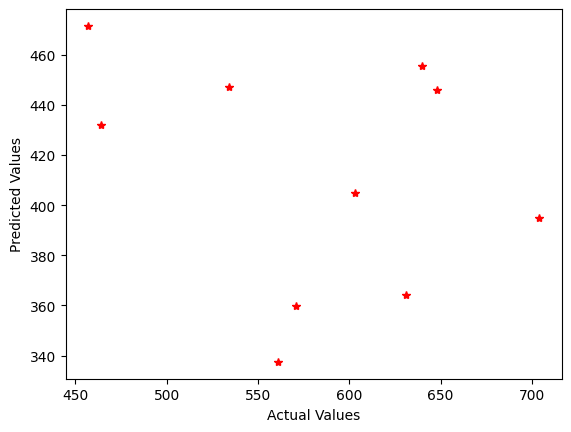

In [27]:
#9 精度评价、模拟绘图制作与模型参数与精度保存

#精度评价与模拟图像就不用过多说啦~
#最后，我们最好将模型参数与精度计量指标结果保存在Excel表格中的这样子旁边借程序。
#这里就不再一介介绍啦，大家对照片代码中的注解即可。

#调用AccuracyVerification函数，进行精度验证指标的计算与绘图
AccuracyResult=AccuracyVerification(PredictValues,TestY)
PearsonR,R2,RMSE,PredictY=AccuracyResult[0],AccuracyResult[1],AccuracyResult[2],AccuracyResult[3]

# 调用WriteAccuracy函数，将模型所涉及的参数与最终精度结果保存
WriteAccuracy(MyResultSavePath,PearsonR,R2,RMSE,TestSize,RandomSeed,OptMethod,LearningRate,DecayStep,
              DecayRate,','.join('%s' %i for i in HiddenLayer),ActFun,Dropout,LossReduction,
              BatchNorm,TrainBatchSize,TrainStep,EvalBatchSize,PredictBatchSize)
#遇到尺寸之类的报错，从头到尾运行